In [188]:
# This is about Modern Portfolio Theory 

In [216]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.optimize as sco

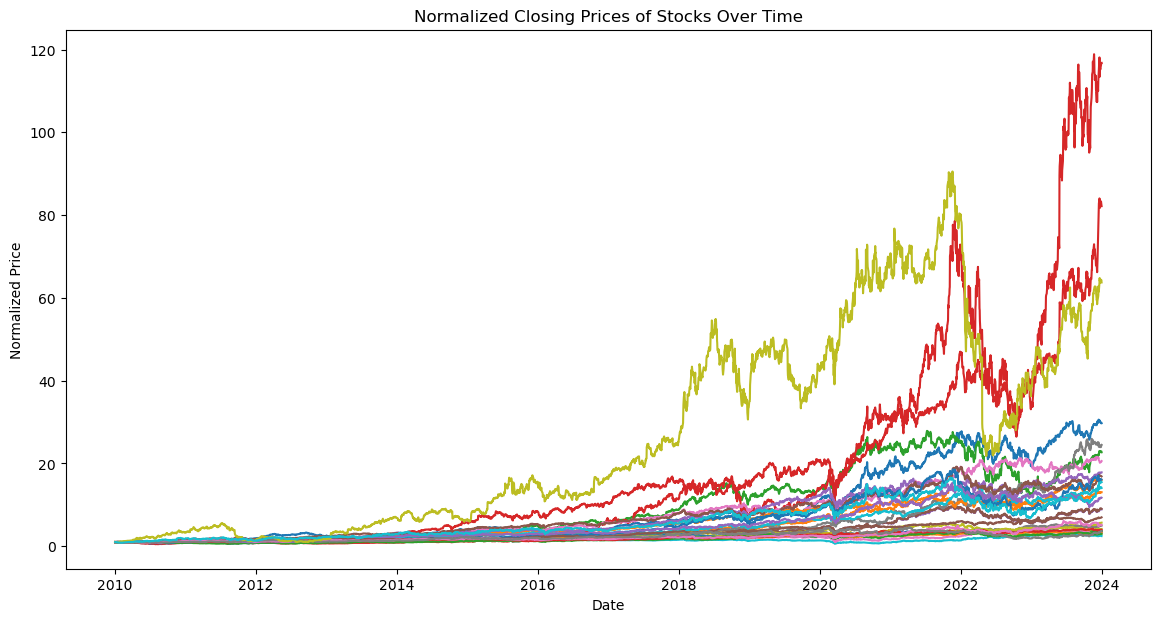

In [240]:
# Creating the stock objects

start_date = "2010-01-01"
end_date = "2024-01-01"
tickers_list = [
    "AAPL", "MSFT", "AMZN", "NVDA", "GOOGL", "GOOG", "UNH",
    "LLY", "JPM", "XOM", "JNJ", "V", "PG", "AVGO", "MA", "HD", "CVX",
    "MRK", "PEP", "COST", "ADBE", "KO", "CSCO", "WMT", "TMO", "MCD",
    "ORCL", "INTC", "NFLX", "CRM"
]

# Adding it to a data frame
close_data = pd.DataFrame()

for ticker in tickers_list:
    ticker_data = yf.Ticker(ticker).history(start=start_date, end=end_date, interval="1d")['Close']
    close_data[ticker] = ticker_data

# Plot the normalised close data over the years

normalised_data = close_data / close_data.iloc[0] # iloc is integer location -> just indexing with pandas

plt.figure(figsize=(14, 7))
for ticker in normalised_data.columns:
    plt.plot(normalised_data.index, normalised_data[ticker], label=ticker)

plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.title('Normalized Closing Prices of Stocks Over Time')
plt.show()


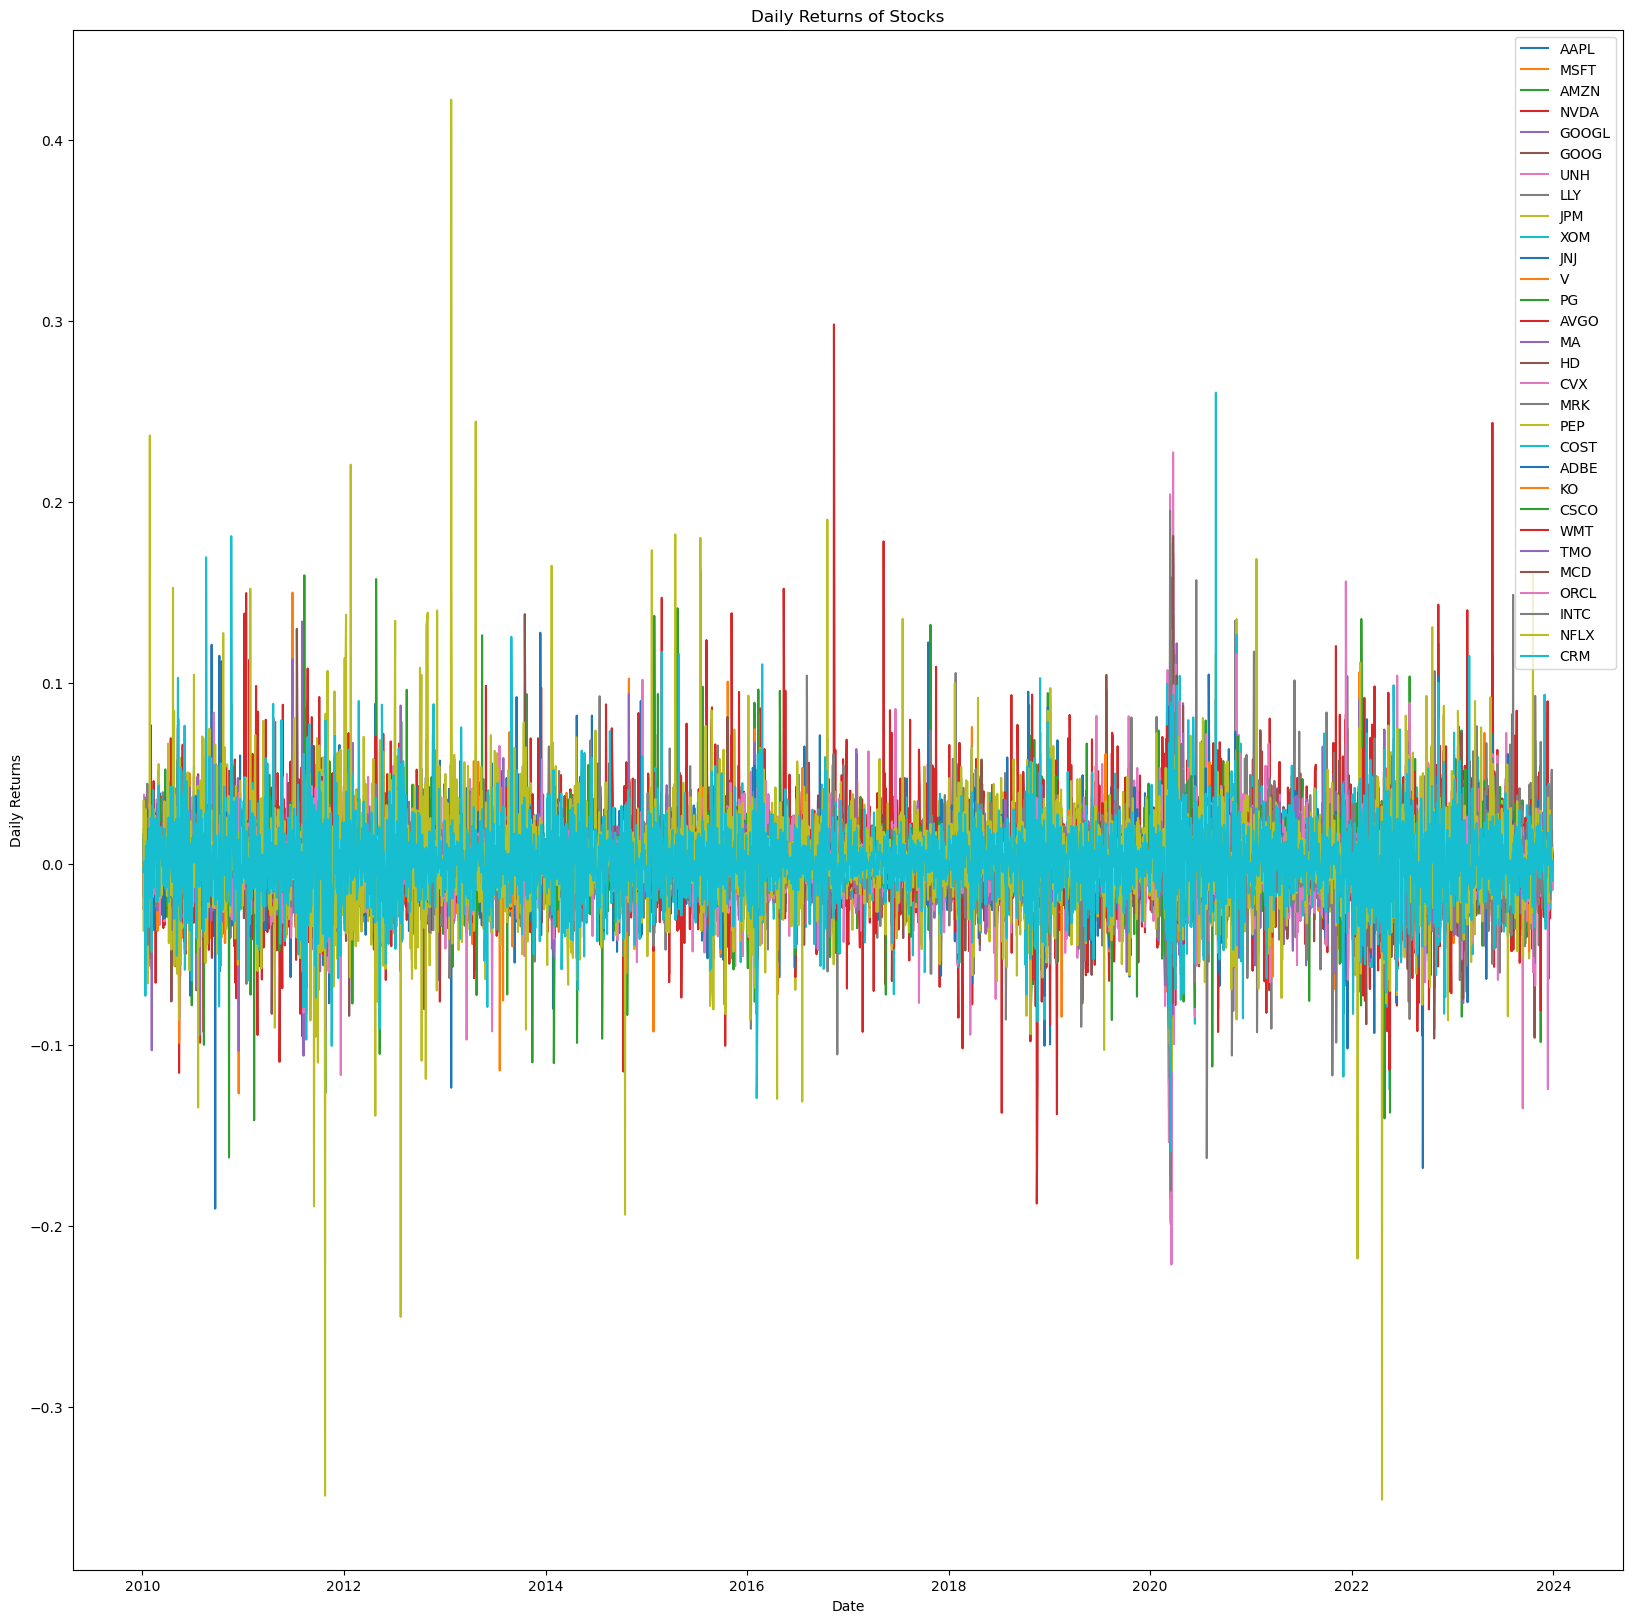

In [242]:
# Turn it into returns data and drop first term

returns_data = close_data.pct_change(fill_method=None).dropna()

# Plotting the returns

plt.figure(figsize=(20, 20))  # Set the figure size
for ticker in returns_data.columns:
    plt.plot(returns_data.index, returns_data[ticker], label=ticker)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.title('Daily Returns of Stocks')
plt.legend()
plt.show()


In [244]:
# Mean returns - * 252 to annualize the returns and standard deviations
mean_returns = returns_data.mean().values * 252

# variance covariance matrix - V Matrix
cov_matrix = returns_data.cov().values * 252

In [246]:
# Let's create a Baseline Portfolio to compare our results to 

# Number of assets
num_assets = len(mean_returns)

# Equal-weight portfolio
equal_weights = np.ones(num_assets) / num_assets

def portfolio_performance(weights, mean_returns, cov_matrix):
    port_return = np.sum(mean_returns * weights)
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return port_return, port_std

# Baseline performance
eq_return, eq_std = portfolio_performance(equal_weights, mean_returns, cov_matrix)
risk_free_rate = 0.02  # example risk-free rate (2%)

eq_sharpe = (eq_return - risk_free_rate) / eq_std

print("Equal Weight Portfolio:")
print(f"Expected Return: {eq_return:.4f}")
print(f"Volatility: {eq_std:.4f}")
print(f"Sharpe Ratio: {eq_sharpe:.4f}")


Equal Weight Portfolio:
Expected Return: 0.2060
Volatility: 0.1740
Sharpe Ratio: 1.0686


In [248]:
# From MPT, we know the formula for the minimum variance weights are given by: 

# W_mv = ((V^-1)e)/(e'(V^-1)e)
ones = np.ones(num_assets)

if np.linalg.det(cov_matrix) != 0:
    cov_matrix_inverse = np.linalg.inv(cov_matrix)
else:
    raise ValueError("Covariance matrix is singular and cannot be inverted.")

w_mv = np.dot(cov_matrix_inverse, ones) / np.dot(ones.T, np.dot(cov_matrix_inverse, ones)) 
print(f"\nThe minimum variance portfolio is given by: {w_mv}")
print(f"Sum of weights: {np.sum(w_mv):.1f}")

mvp_expected_return = np.dot(w_mv.T, mean_returns)
print(f"Expected return of the Minimum Variance Portfolio: {mvp_expected_return}")

var = (np.dot(ones.T, np.dot(cov_matrix_inverse, ones))) ** -1
print(f"Variance of the Minimum Variance Portfolio: {var}")
mvp_std = np.sqrt(var)


The minimum variance portfolio is given by: [ 0.01843604 -0.03628052  0.034006   -0.01555414 -0.08263035  0.11492944
 -0.01105206  0.02866725 -0.04287448  0.11634772  0.20633821  0.06632413
  0.12544728 -0.00472595 -0.10922144 -0.01524569 -0.0607353   0.06868398
  0.022724    0.06347255 -0.01680272  0.15724214 -0.01773701  0.16107979
  0.01393435  0.19620423  0.00728045 -0.00120716  0.01409068 -0.00114141]
Sum of weights: 1.0
Expected return of the Minimum Variance Portfolio: 0.1190636303117789
Variance of the Minimum Variance Portfolio: 0.016792799031183823


In [250]:
## Finding the Minimum Variance Frontier for a specific portfolio return.


Portfolio on the frontier for a 10% return: [ 0.00928104 -0.04131876  0.03305561 -0.02473419 -0.06839919  0.11246701
 -0.02469946  0.00371371 -0.04360185  0.12368721  0.22636064  0.06961528
  0.13192532 -0.01935893 -0.12017753 -0.02596398 -0.0584008   0.07380993
  0.02705055  0.04485175 -0.01369666  0.17103978 -0.00274421  0.17290106
  0.01270456  0.19352089  0.01464327  0.01330993  0.00814058  0.00101747]
Sum of weights: 1.0
Variance of the target portfolio: 0.01694596878601177


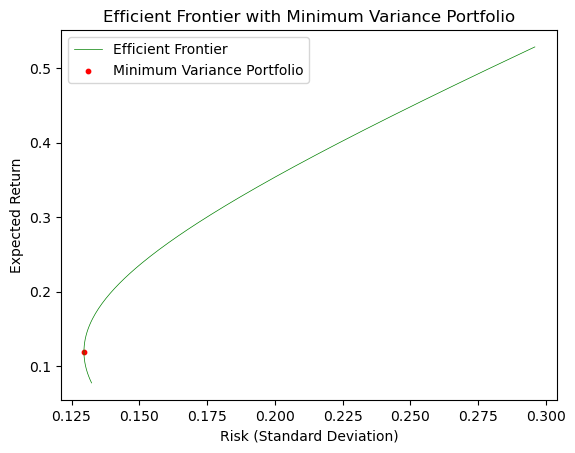

In [252]:
set_target_return = 0.10
A = np.dot(mean_returns.T, np.dot(cov_matrix_inverse, mean_returns))
B = np.dot(ones.T, np.dot(cov_matrix_inverse, mean_returns))
C = np.dot(ones.T, np.dot(cov_matrix_inverse, ones))
D = (A * C) - (B ** 2)

lambda_1 = ((C * set_target_return) - B) / D
lambda_2 = (A - (B * set_target_return)) / D

w_target = lambda_1 * np.dot(cov_matrix_inverse, mean_returns) + lambda_2 * np.dot(cov_matrix_inverse, ones)
print(f"\nPortfolio on the frontier for a 10% return: {w_target}")
print(f"Sum of weights: {np.dot(w_target.T, ones):.1f}")

R_p = np.dot(w_target.T, mean_returns)
if round(R_p, 2) != set_target_return:
    print(f"Warning: The portfolio return {R_p} doesn't match the targeted return of {set_target_return}")
    
port_variance_example = np.dot(w_target.T, np.dot(cov_matrix, w_target))
print(f"Variance of the target portfolio: {port_variance_example}")

# Efficient Frontier Generation

# Feasible range of returns, from just below MVP to something near the highest asset
range_start = 0.8 * np.min(mean_returns)
range_end = 1.2 * np.max(mean_returns)
full_returns = np.linspace(range_start, range_end, 200)

full_port_std = []

for Rp in full_returns:
    lambda_1 = (C * Rp - B) / D
    lambda_2 = (A - B * Rp) / D
    w = lambda_1 * np.dot(cov_matrix_inverse, mean_returns) + lambda_2 * np.dot(cov_matrix_inverse, ones)
    portfolio_variance = np.dot(w.T, np.dot(cov_matrix, w))
    full_port_std.append(np.sqrt(portfolio_variance))

# Plotting the whole mean-variance frontier - standard deviation on x-axis and portfolio return on the y-axis.

# The MVF shows us the set of portfolios that offer the highest expected return for a given level of risk. 
# So now we need to generate a range of returns to form the corresponding portfolios for the frontier.

# Plot the efficient frontier
plt.plot(full_port_std, full_returns, 'g-', linewidth=0.5, label='Efficient Frontier')

# Plot the minimum variance portfolio point on top of the efficient frontier
plt.scatter(mvp_std, mvp_expected_return, color='red', marker='o', s=10, label='Minimum Variance Portfolio')

# Labels
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Minimum Variance Portfolio')
plt.legend()
plt.show()

In [254]:
# Optimise the Portfolio (Maximise Sharpe Ratio)

# We define a function to compute negative Sharpe ratio for optimisation since sco.minimize is 
# designed to minimize functions, by minimizing the negative Sharpe ratio,
# we effectively Maximise the Sharpe ratio

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_return, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_return - risk_free_rate) / p_std

# Constraints and bounds for long-only portfolio
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))
initial_guess = num_assets * [1. / num_assets]

opt_result = sco.minimize(negative_sharpe_ratio, initial_guess, 
                          args=(mean_returns, cov_matrix, risk_free_rate),
                          method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = opt_result.x

opt_return, opt_std = portfolio_performance(optimal_weights, mean_returns, cov_matrix)
opt_sharpe = (opt_return - risk_free_rate) / opt_std

print("\nOptimised Portfolio (Maximising Sharpe Ratio):")
print(f"Expected Return: {opt_return:.4f}")
print(f"Volatility: {opt_std:.4f}")
print(f"Sharpe Ratio: {opt_sharpe:.4f}")

improvement = ((opt_sharpe / eq_sharpe) - 1) * 100
print(f"Percentage improvement in Sharpe Ratio over Equal Weight: {improvement:.2f}%")

vol_reduction = ((eq_std - opt_std) / eq_std) * 100
print(f"Percentage reduction in portfolio volatility: {vol_reduction:.2f}%")


Optimised Portfolio (Maximising Sharpe Ratio):
Expected Return: 0.2922
Volatility: 0.1893
Sharpe Ratio: 1.4381
Percentage improvement in Sharpe Ratio over Equal Weight: 34.57%
Percentage reduction in portfolio volatility: -8.77%


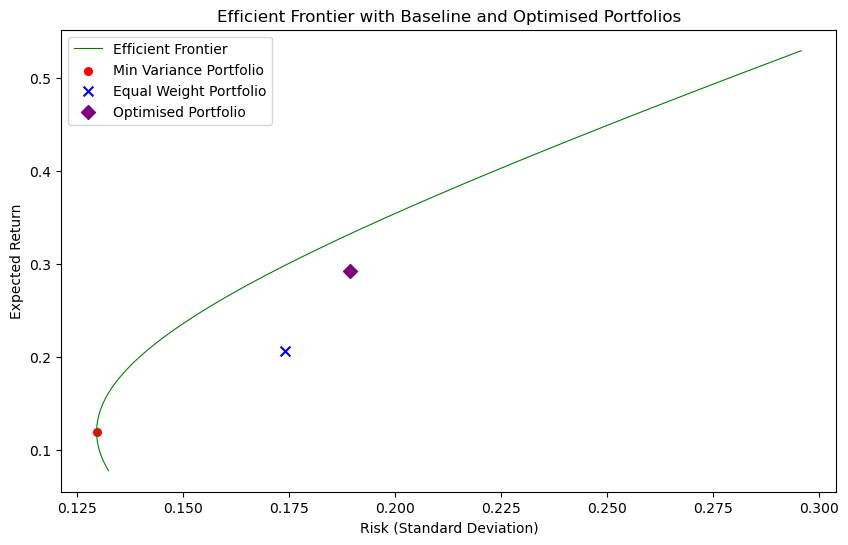

In [256]:
# Plotting: Efficient Frontier with Additional Portfolios

plt.figure(figsize=(10, 6))
plt.plot(full_port_std, full_returns, 'g-', linewidth=0.8, label='Efficient Frontier')

# Minimum Variance Portfolio Point
plt.scatter(mvp_std, mvp_expected_return, color='red', marker='o', s=30, label='Min Variance Portfolio')

# Baseline (Equal Weight) Portfolio Point
plt.scatter(eq_std, eq_return, color='blue', marker='x', s=50, label='Equal Weight Portfolio')

# Optimised (Max Sharpe) Portfolio Point
plt.scatter(opt_std, opt_return, color='purple', marker='D', s=50, label='Optimised Portfolio')

plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Baseline and Optimised Portfolios')
plt.legend()
plt.show()

In [201]:
##############################################################################################################################################